# Scale Free Network simulations

In [534]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import EoN
import networkx as nx
import pandas as pd
import scipy.interpolate
from collections import defaultdict
import random

In [554]:
def _simple_test_transmission_(v, infecteds):
    ## v is a susceptible node
    return random.random()<p

def discrete_SIR2(G, test_transmission = _simple_test_transmission_, args = (), 
                initial_infecteds = None, initial_recovereds = None, 
                rho = None, tmin = 0, tmax = float('Inf'),
                return_full_data = False, sim_kwargs = None):

    if rho is not None and initial_infecteds is not None:
        raise EoN.EoNError("cannot define both initial_infecteds and rho")

    if initial_infecteds is None:  #create initial infecteds list if not given
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
    #else it is assumed to be a list of nodes.

    if return_full_data:
        node_history = defaultdict(lambda : ([tmin], ['S']))
        transmissions = []
        for node in initial_infecteds:
            node_history[node] = ([tmin], ['I'])
            transmissions.append((tmin - 1, None, node))
        if initial_recovereds is not None:
            for node in initial_recovereds:
                node_history[node] = ([tmin], ['R'])
    
    N = G.order()
    t = [tmin]
    S = [N - len(initial_infecteds)]
    I = [len(initial_infecteds)]
    R = [0]
    
    susceptible = defaultdict(lambda: True)  
    #above line is equivalent to u.susceptible=True for all nodes.
    
    for u in initial_infecteds:
        susceptible[u] = False
    if initial_recovereds is not None:
        for u in initial_recovereds:
            susceptible[u] = False
        
    infecteds = set(initial_infecteds)
    all_nodes = G.nodes
    
    while infecteds and t[-1]<tmax:

        new_infecteds = set()
        # try to see if there is contamination for all susceptibles
        for v in all_nodes:
            if susceptible[v] and test_transmission(v, infecteds):
                new_infecteds.add(v)
                susceptible[v] = False
 
        infecteds = new_infecteds

        R.append(R[-1]+I[-1])
        I.append(len(infecteds))
        S.append(S[-1]-I[-1])
        t.append(t[-1]+1)
    return np.array(t), np.array(S), np.array(I), \
               np.array(R)

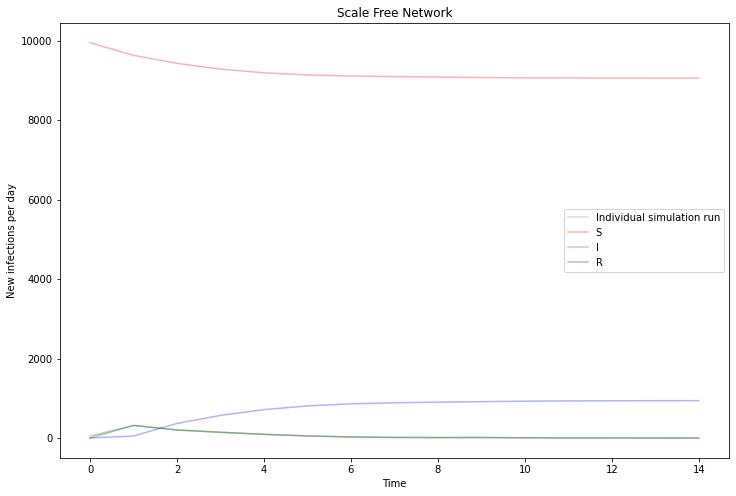

<Figure size 432x288 with 0 Axes>

In [555]:
N = 10**4
kave = 10
G = nx.barabasi_albert_graph(N, kave)
tmin = 0
tmax = 200
simulationRuns = 1

tau = 0.025    #transmission rate
gamma = 0.1     #recovery rate
rho = 0.005
step = 0.1     #step size

xx = np.arange(0, tmax, step)
yy = np.arange(0, tmax, step)

nb_initial_infecteds = 50
initial_infecteds = range(nb_initial_infecteds)

# change the figure size
plt.figure(figsize=(12,8))

# We define our specific rule for the propagation
def f(v, infecteds):
    dt = 1 # Apparently discrete_SIR increase the step by one
    ni = 0 # number of infected nodes connected to v
    for n in G[v]:
        if n in infecteds:
            ni = ni + 1
    p = 1 - np.exp(- tau * ni * dt)
    return random.random() < p 

for counter in range(simulationRuns):
    
    t, S, I, R = discrete_SIR2(G, test_transmission = f, initial_infecteds = initial_infecteds)
    # computence incidence
    incidence = - np.diff(S)
    for x in range(1, S.size - 1):
        incidence[x] = -(S[x + 1] - S[x]) / (t[x + 1] - t[x])
    incidence = np.concatenate(([0], incidence))
    
    if counter == 0: #Print label only for 1st run
        plt.plot(t, incidence, color = 'gray', alpha = 0.3, label = 'Individual simulation run') 
    plt.plot(t, incidence, color = 'gray', alpha = 0.3)

    # Plots of S, I, R
    plt.plot(t, S, color = 'red', alpha = 0.3, label = 'S')
    plt.plot(t, I, color = 'green', alpha = 0.3, label = 'I')
    plt.plot(t, R, color = 'blue', alpha = 0.3, label = 'R')

#df1 = pd.read_csv('Sources/Aparicio_ScaleFreS.csv')
#df1 = df1.loc[:, '{#status->#S}']
#df1 = df1*N
#inc1 = - df1.diff()
#inc1 = inc1[:2000]

#df2 = pd.read_csv('Sources/Stroud_HMS.csv')
#df2 = df2.loc[:, '{#status->#S}']
#df2 = df2*N
#inc2 = - df2.diff()
#inc2 = inc2[:2000]

#df3 = pd.read_csv('Sources/Stroud_ScaleS.csv')
#df3 = df3.loc[:, '{#status->#S}']
#df3 = df3*N
#inc3 = - df3.diff()
#inc3 = inc3[:2000]

#plt.plot(xx, inc1, '--', label = 'Aparicio simulation', color = 'green')
#plt.plot(xx, inc2, label = 'Homogeneous mixing simulation', color = 'red')
#plt.plot(xx, inc3, '-.', label = 'Stroud simulation', color = 'blue')

plt.xlabel('Time')
plt.ylabel('New infections per day')
plt.title('Scale Free Network')
plt.legend()
plt.show()
plt.savefig('Plot/Scale_Free_network.png')